In [1]:
%pylab inline
import pandas as pd
import time
#import numpy as np
import pickle
import joblib
import copy as cp
from joblib import Parallel, delayed
import os
import csv
from pandas import *
import datetime as dt
from datetime import date, datetime, timedelta
from sklearn import svm, preprocessing
from collections import Counter
from sklearn import linear_model as lm
import math as math
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from ggplot import *
from sklearn.linear_model import SGDRegressor
from scipy import stats
from scipy.stats import binned_statistic, binned_statistic_dd
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier

plt.style.use('seaborn-white')
pandas.set_option('display.max_columns', None)

Populating the interactive namespace from numpy and matplotlib


In [2]:
with open("pickles/preppedBaseFrames2.pkl",'rb') as f: 
    allSamples2, hadmsList, currStates, nextStates, actions, rewards = pickle.load(f)

allSamples = {}
for i in range(len(allSamples2)):
    h = allSamples2[i]['hadm']
    allSamples[h] = allSamples2[i]

In [3]:
currStates = np.concatenate(currStates)
nextStates = np.concatenate(nextStates)
ventActions = np.transpose(actions)[0]
inputActions = np.transpose(actions)[9]
inputActionsign = (sign(inputActions))
hadms = unique(hadmsList)
scaler = StandardScaler()  
scaler.fit(currStates)
currStatesScaled = scaler.transform(currStates)
nextStatesScaled = scaler.transform(nextStates)

In [4]:
ventoff = list(np.concatenate(np.where(np.transpose(actions[:195663])[0]==0)))
#indices = (np.hstack([range(trainSize), ventoff, ventoff, ventoff, ventoff, ventoff]))

In [5]:
counterActions = [(0,0), (0,1), (0,-1)]

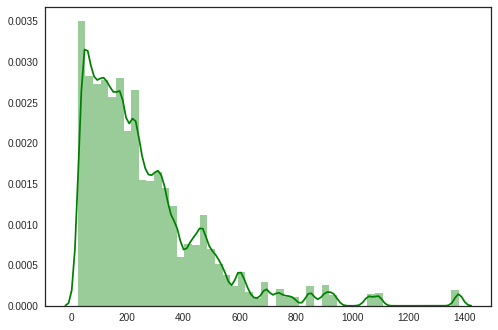

In [4]:
sns.distplot([(len(allSamples[h]['actions'])) for h in hadmsList], color='g')

In [6]:
counterStates = []
counterNext = []
for h in hadms:
    for s in range(len(allSamples[h]['currStates'])):
        dur =  np.concatenate(allSamples[h]['currStates'][s])[32]
        vent =  (allSamples[h]['actions'][s])[0]
        if dur > 0 and dur <= 6 and vent == 1:
            #print np.concatenate(allSamples[h]['currStates'][s])[32], (allSamples[h]['actions'][s])[0]
            counterStates.append(allSamples[h]['currStates'][s])
            counterNext.append(allSamples[h]['nextStates'][s])
counterRewards = np.ones((len(counterStates),1)) *-1.5
counterSamples = np.hstack([scaler.transform(np.concatenate(counterStates)), np.zeros((len(counterStates),1))])

In [7]:
# for 6 actions
counterSamples = np.vstack([np.hstack([scaler.transform(np.concatenate(counterStates)), np.ones((len(counterStates),2)) *counterActions[0]]), 
np.hstack([scaler.transform(np.concatenate(counterStates)), np.ones((len(counterStates),2)) *counterActions[1]]),
np.hstack([scaler.transform(np.concatenate(counterStates)), np.ones((len(counterStates),2)) *counterActions[2]])])
counterNext = (np.vstack([counterNext, counterNext, counterNext]))
counterRewards = np.ones((len(counterStates)*3,1)) *-1.5
counterSamples = np.hstack([scaler.transform(np.concatenate(counterStates)), np.zeros((len(counterStates),1))])

In [8]:
feats = ['Admit Type', 'Ethnicity', 'Gender', 'Age', 'Weight', 
         'Heart Rate', 'Respiratory Rate','$O_2$ saturation pulseoxymetry', 'NI Blood Pressure (Mean)', 
        '$O_2$ Flow', 'Inspired $O_2$ Fraction', 'Arterial $CO_2$ Pressure', 'Arterial pH', 'Arterial $O_2$ pressure', 
        'Mean Airway Pressure', 'Ventilator Mode', 'Peak Insp. Pressure', 'Plateau Pressure', 'Minute Volume', 
        'Tidal Volume', 'PEEP set', 'Creatinine', 'Hematocrit', 'Blood Urea Nitrogen (BUN)',
         'Fentanyl (Concentrate)', 'Midazolam (Versed)', 'Propofol','Fentanyl', 'Dexmedetomidine (Precedex)', 
        'Morphine Sulfate','Hydromorphone (Dilaudid)', 'Lorazepam (Ativan)',
        'Duration', 'Intubations']

In [9]:
trainPts = hadms[:1500]
testPts = hadms[1500:]
trainStates = {}; testStates = {}
trainnextStates = {}; testnextStates = {}
trainActions = {}; testActions = {}
trainRewards = {}; testRewards = {}
trainSamples = {}; testSamples = {}

for h in trainPts:
    trainStates[h] = scaler.transform(np.concatenate(allSamples[h]['currStates']))
    trainnextStates[h] = scaler.transform(np.concatenate(allSamples[h]['nextStates']))
    trainActions[h] = np.transpose([np.transpose(allSamples[h]['actions'])[0], 
                                    sign(np.transpose(allSamples[h]['actions'])[9])])
    trainActions[h] = np.concatenate(sign([np.transpose(allSamples[h]['actions'])[9]]))
    trainRewards[h] = allSamples[h]['rewards']
    #trainSamples[h] = np.hstack([trainStates[h], trainActions[h]])
    trainSamples[h] = np.hstack([(trainStates[h]), np.transpose([(trainActions[h])])])
    
allTrainSamples = np.concatenate([trainSamples[h] for h in trainPts])
allTrainNext =  np.concatenate([trainnextStates[h] for h in trainPts])
allTrainRewards =  np.concatenate([trainRewards[h] for h in trainPts])

possibleActions = [0, 1]
#possibleActions = unique(np.concatenate([trainActions[h] for h in trainPts]))
#possibleActions = unique(np.transpose(np.array(list(possibleActions)))[0])

for h in testPts:
    testStates[h] = scaler.transform(np.concatenate(allSamples[h]['currStates']))
    testnextStates[h] = scaler.transform(np.concatenate(allSamples[h]['nextStates']))
    testActions[h] = np.transpose([np.transpose(allSamples[h]['actions'])[0], 
                                    sign(np.transpose(allSamples[h]['actions'])[9])])
    testRewards[h] = allSamples[h]['rewards']
    testSamples[h] = np.hstack([testStates[h], testActions[h]])

allTestSamples = np.concatenate([testSamples[h] for h in testPts])

allTrainSamples = np.vstack([allTrainSamples, counterSamples])
allTrainNext = np.vstack([allTrainNext, scaler.transform(np.concatenate(counterNext))])
allTrainRewards = np.concatenate([allTrainRewards, np.concatenate(counterRewards)])

trainSize = len(allTrainSamples)
testSize = len(allTestSamples)
print trainSize, testSize

209013 68203


In [833]:
possibleActions

[0, 1]

In [834]:
np.unique(optA, return_counts=True)

(array([0, 1]), array([21817, 38183]))

In [ ]:
# Get subset of feature space
allTrainSamples = np.transpose((np.transpose(allTrainSamples)[list(np.concatenate([range(24) + [34]]))]))
allTrainNext = np.transpose(np.transpose(allTrainNext)[:24])
allTestSamples = np.transpose((np.transpose(allTestSamples)[list(np.concatenate([range(24) + [34]]))]))

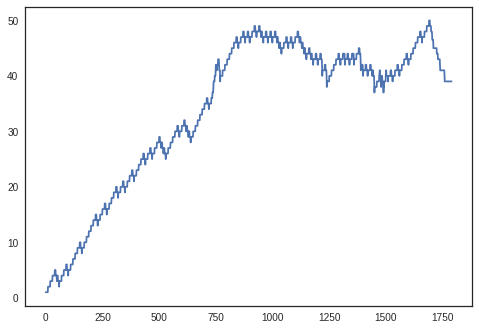

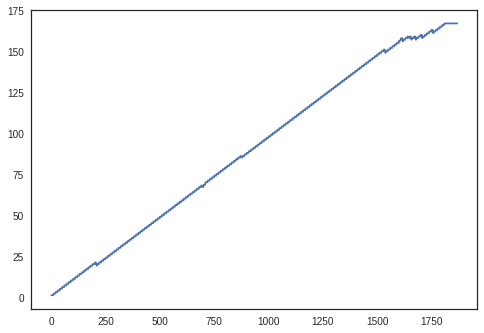

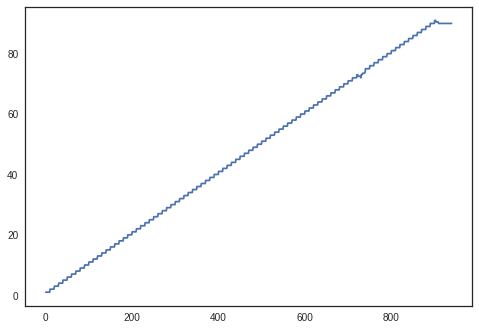

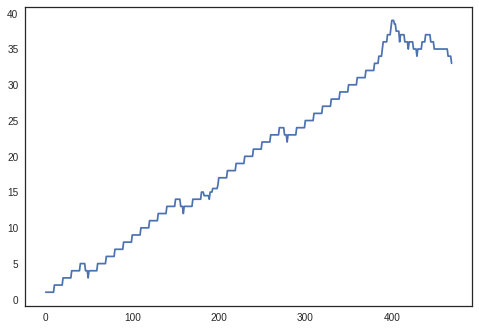

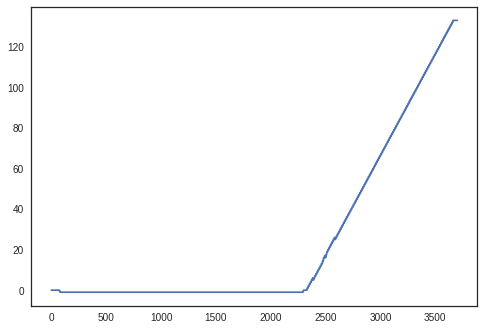

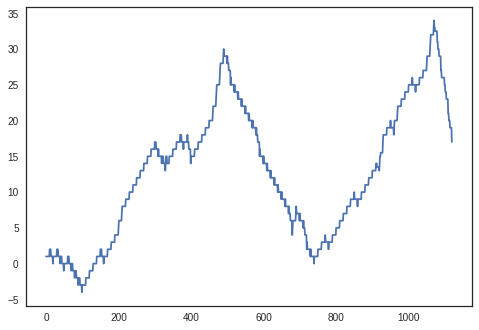

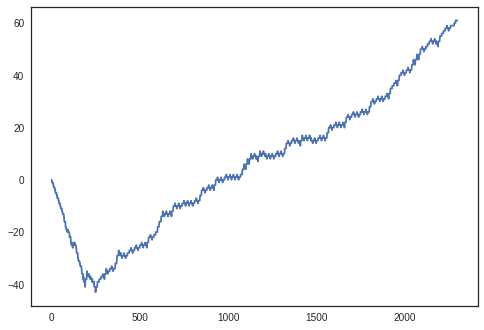

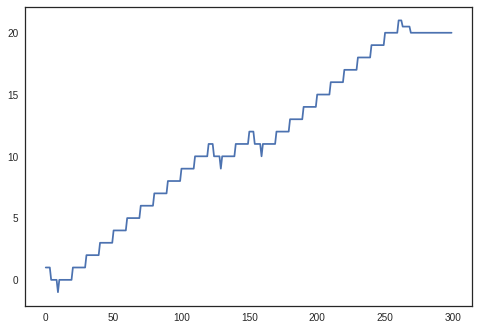

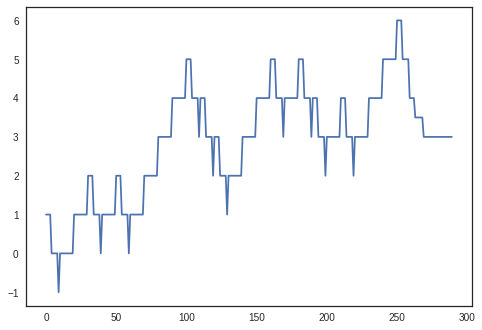

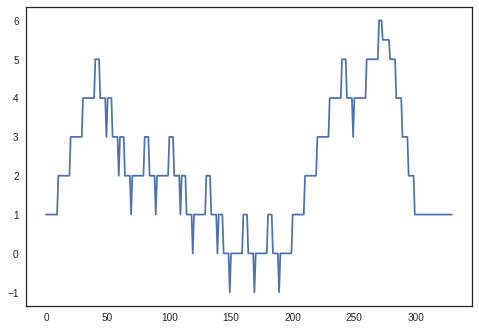

In [823]:
for i in range(0,10):
    figure()
    plot(cumsum(allSamples[hadms[i]]['actions']))

In [249]:
np.transpose(np.transpose(allSamples[h]['actions'])[0])
#np.hstack((allTrainNext[s], [a]))
np.hstack([(trainStates[h]), np.transpose([(trainActions[h])])])

array([[ 0.34582418, -1.5531993 , -0.8460166 , ..., -0.85563522,
        -0.20342042,  1.        ],
       [ 0.34582418, -1.5531993 , -0.8460166 , ..., -0.844582  ,
        -0.20342042,  1.        ],
       [ 0.34582418, -1.5531993 , -0.8460166 , ..., -0.83352877,
        -0.20342042,  1.        ],
       ..., 
       [ 0.34582418, -1.5531993 , -0.8460166 , ..., -0.86668845,
        -0.20342042,  0.        ],
       [ 0.34582418, -1.5531993 , -0.8460166 , ..., -0.86668845,
        -0.20342042,  0.        ],
       [ 0.34582418, -1.5531993 , -0.8460166 , ..., -0.86668845,
        -0.20342042,  0.        ]])

array([1, 2, 0])

In [767]:
def fitTree(samples,targets):
    clf = ExtraTreesRegressor(n_estimators=50, max_depth=None, min_samples_leaf=50, random_state=1, warm_start=False)
    clf.fit(samples, targets)
    return clf
def fitNN(samples, targets):
    clf = MLPRegressor(solver='adam', alpha=1e-5,learning_rate='adaptive',hidden_layer_sizes=(5,2), random_state=None)
    clf.fit(samples, targets)
    return clf
def partialfitNN(clf, samples, targets):
    clf.partial_fit(samples, targets)
    return clf

batchSize = 60000
indices = (np.hstack([range(trainSize), ventoff, ventoff, ventoff, ventoff, ventoff]))
print 'Initialization'
batch = unique(random.choice(indices, batchSize, replace=False))
#batch = range(trainSize)
#Qtree = fitTree([allTrainSamples[s] for s in batch], [allTrainRewards[s] for s in batch])
Qnn = fitNN([allTrainSamples[s] for s in batch], [allTrainRewards[s] for s in batch])
gamma = 0.9
Q = np.zeros((len(possibleActions), trainSize))
#Q = 0.1 * np.random.randn(len(possibleActions), trainSize)
Qdist = []

print 'Q-iteration'
iter = 0 
while iter < 100:
    batch = random.choice(indices, batchSize, replace=False)     
    S = {}
    Qold = cp.deepcopy(Q) 
    anum = 0
    for a in possibleActions:
        #Q[anum,batch] = Qtree.predict([np.hstack((allTrainNext[s], a)) for s in batch])
        Q[anum,batch] = Qnn.predict([np.hstack((allTrainNext[s], [a])) for s in batch])
        anum += 1
    Qdist.append(np.array(mean(abs(np.matrix(Qold) - np.matrix(Q)))))
    
    optA = [np.argmax(np.transpose(Q[:,s])) for s in batch]
    T = [(allTrainRewards[s] + gamma*max(np.transpose(Q[:,s]))) for s in batch]
    #Qtree = fitTree([allTrainSamples[s] for s in batch], T)
    Qnn = partialfitNN(Qnn,[allTrainSamples[s] for s in batch], T)
    S = {'n': batch, 'T': T, 'optA': optA}
    print 'Iter:', iter, '; Qdiff:', Qdist[len(Qdist)-1]    
    iter = iter + 1

Initialization
Q-iteration
Iter: 0 ; Qdiff: 0.356180249813
Iter: 1 ; Qdiff: 0.535177085201
Iter: 2 ; Qdiff: 0.631029305352
Iter: 3 ; Qdiff: 0.683121386732
Iter: 4 ; Qdiff: 0.722975151991
Iter: 5 ; Qdiff: 0.72863978235
Iter: 6 ; Qdiff: 0.717832380965
Iter: 7 ; Qdiff: 0.694243062768
Iter: 8 ; Qdiff: 0.661776230639
Iter: 9 ; Qdiff: 0.629056240596
Iter: 10 ; Qdiff: 0.596940564918
Iter: 11 ; Qdiff: 0.559143434157
Iter: 12 ; Qdiff: 0.524132269736
Iter: 13 ; Qdiff: 0.490577219062
Iter: 14 ; Qdiff: 0.461179297164
Iter: 15 ; Qdiff: 0.418392339239
Iter: 16 ; Qdiff: 0.391185372122
Iter: 17 ; Qdiff: 0.359258897633
Iter: 18 ; Qdiff: 0.323943617495
Iter: 19 ; Qdiff: 0.303494585533
Iter: 20 ; Qdiff: 0.274204278566
Iter: 21 ; Qdiff: 0.258425688726
Iter: 22 ; Qdiff: 0.232169433049
Iter: 23 ; Qdiff: 0.198829422293
Iter: 24 ; Qdiff: 0.187412413405
Iter: 25 ; Qdiff: 0.179273367222
Iter: 26 ; Qdiff: 0.163288952746
Iter: 27 ; Qdiff: 0.149346031802
Iter: 28 ; Qdiff: 0.134388653477
Iter: 29 ; Qdiff: 0.1244469

In [504]:
#with open("pickles/misc16MayNNsubset.pkl",'wb') as f: pickle.dump((Qnn, Q, Qold, Qdist, S, optA), f)
with open("pickles/misc16MayTreesubset.pkl",'wb') as f: pickle.dump((Qtree, Q, Qold, Qdist, S, optA), f)
    
#with open("pickles/misc16MayNNsubset-seds.pkl",'wb') as f: pickle.dump((Qnn, Q, Qold, Qdist, S, optA), f)

In [10]:
with open("pickles/misc16MayTreesubset.pkl",'rb') as f: 
    Qtree, Q, Qold, Qdist, S, optA = pickle.load(f)
with open("pickles/misc16MayNNsubset.pkl",'rb') as f: 
    Qnn, nnQ, nnQold, nnQdist, nnS, nnoptA = pickle.load(f)

In [ ]:
plt.style.use('seaborn-white')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'grid.color':'lightgrey'})
figsize(12,8)
plot(Qdist, label='FQI w/ Extra-Trees', linewidth=2, color=sns.color_palette('Set2')[0])
plt.legend(fontsize=16)
plt.xlabel('Iteration Number $k$', size=16)
plt.ylabel('Mean $\Delta (\hat{Q}_k, \hat{Q}_{k-1})$', size=16)
plt.xticks(size=14)
plt.yticks(size=14)

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8]),
 <a list of 10 Text yticklabel objects>)

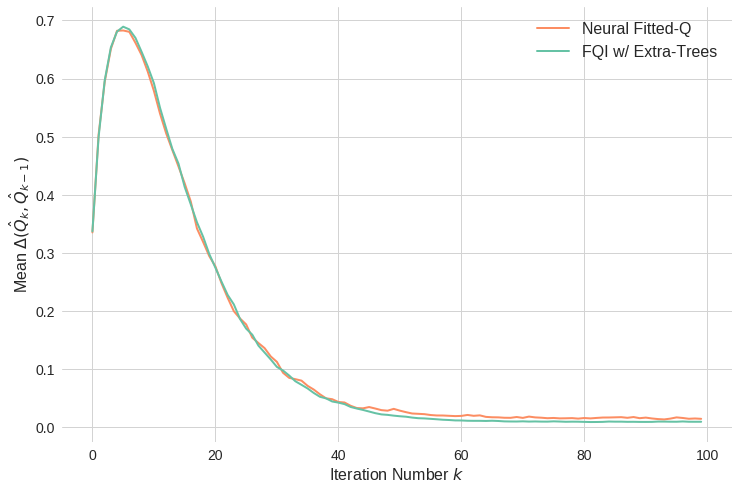

In [78]:
plt.style.use('seaborn-white')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'grid.color':'lightgrey'})
figsize(12,8)
hold(True)
plot(nnQdist, label='Neural Fitted-Q', linewidth=2, color=sns.color_palette('Set2')[1])
plot(Qdist, label='FQI w/ Extra-Trees', linewidth=2, color=sns.color_palette('Set2')[0])
plt.legend(fontsize=16)
plt.xlabel('Iteration Number $k$', size=16)
plt.ylabel('Mean $\Delta (\hat{Q}_k, \hat{Q}_{k-1})$', size=16)
plt.xticks(size=14)
plt.yticks(size=14)

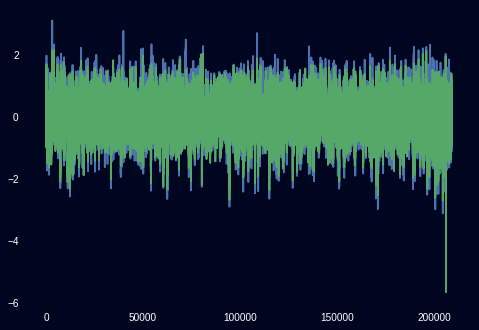

In [77]:
plot(Q[1]-nnQ[1])
plot(Q[0]-nnQ[0])

In [16]:
def fitCtree(states, actions):
    clf = ExtraTreesClassifier(n_estimators=500, max_depth=None, min_samples_leaf=50, class_weight='balanced')
    clf.fit(states, actions)
    return clf

use = range(24)
def plotImportances(Q):
    optA = [np.argmax(np.transpose(Q[:,s])) for s in range(trainSize)]
    policyTree = fitCtree([currStatesScaled[s][use] for s in range(trainSize)], optA) 
    importances = policyTree.feature_importances_
    std = np.std([tree.feature_importances_ for tree in policyTree.estimators_],axis=0)
    featImportances = pd.DataFrame(data={"feats": [feats[x] for x in use], "importances": importances}, 
                                   index=[feats[x] for x in use])
    return importances, featImportances, policyTree

imp1, fi1, ptree1 = plotImportances(Q)
imp2, fi2, ptree2 = plotImportances(nnQ)

In [ ]:
import matplotlib.cm as cm
import operator as o
import itertools
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'grid.color':'whitesmoke'})

fig = plt.figure()
ax = plt.subplot()
fig.set_size_inches(16,10)

dpoints=np.transpose(np.hstack([
            np.vstack([['FQI w/ Extra-Trees']*len(use), [feats[x] for x in use], imp1]),
            np.vstack([['Neural Fitted-Q']*len(use), [feats[x] for x in use], imp2])

        ]))

def barplot(ax, dpoints):
    '''
    Create a barchart for data across different categories with
    multiple conditions for each category.
    
    @param ax: The plotting axes from matplotlib.
    @param dpoints: The data set as an (n, 3) numpy array
    '''
    palette = itertools.cycle(sns.color_palette('Set2'))
    palette = itertools.cycle([sns.color_palette('Set2')[0],sns.color_palette('Set2')[4]])

    # Aggregate the conditions and the categories according to their
    # mean values
    conditions = [(c, np.mean(dpoints[dpoints[:,0] == c][:,2].astype(float))) 
                  for c in np.unique(dpoints[:,0])]
    categories = [(c, np.mean(dpoints[dpoints[:,1] == c][:,2].astype(float))) 
                  for c in np.unique(dpoints[:,1])]
    
    # sort the conditions, categories and data so that the bars in
    # the plot will be ordered by category and condition
    conditions = [c[0] for c in sorted(conditions, key=o.itemgetter(1))]
    categories = [c[0] for c in sorted(categories, key=o.itemgetter(1))]
    
    dpoints = np.array(sorted(dpoints, key=lambda x: categories.index(x[1])))

    # the space between each set of bars
    space = 0.3
    n = len(conditions)
    width = 0.3
    height = (1 - space) / (len(conditions))
    
    # Create a set of bars at each position
    for i,cond in enumerate(conditions):
        indeces = range(1, len(categories)+1)
        vals = dpoints[dpoints[:,0] == cond][:,2].astype(np.float)
        pos = [j - (1 - space) / 2. + i * height for j in indeces]
        ax.barh(pos, vals, height=width, label=cond, color=next(palette))
    
    # Set the x-axis tick labels to be equal to the categories
    ax.set_yticks(indeces)
    ax.set_yticklabels(categories, size=12)
    #plt.setp(plt.xticks()[1], rotation=0)
    
    # Add the axis labels
    ax.set_xlabel("Feature Importance",size=12)
    ax.set_ylabel("", size=12)
    ax.set_ylim([0, len(categories)+1])
    # Add a legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='lower right',fontsize=12)
        
barplot(ax, dpoints)
plt.show()

## Testing 
---------------

In [13]:
allTestStates = np.concatenate([testStates[h] for h in testPts])
allTestActions = np.concatenate([testActions[h] for h in testPts])

In [448]:
len(allTestStates[0])

34

In [23]:
import numpy_indexed as npi
unique_rows, row_count = npi.count(allTestActions, axis=0)
unique_rows, row_count

(array([[ 0.,  0.],
        [ 0.,  1.],
        [ 0., -1.],
        [ 1.,  0.],
        [ 1.,  1.],
        [ 1., -1.]]), array([ 8433,   138,   763, 31571,  3540, 23758]))

In [511]:
h = 1808
piRL(hadms[h], 0, ptree2), piHosp(hadms[h], 0)

(array([ 0.0820576 ,  0.06504571,  0.06465204,  0.07688355,  0.11658218,
         0.11220735,  0.06245355,  0.06246972,  0.08812754,  0.08715011,
         0.08360217,  0.10272674,  0.10187907,  0.06204138,  0.07798224,
         0.08279021,  0.10298013,  0.11509207,  0.10284449,  0.10143298,
         0.15853299,  0.16337094,  0.16760617,  0.18375965,  0.18754219,
         0.16814514,  0.28904323,  0.27408833,  0.33260692,  0.32197033,
         0.27838837,  0.26737791,  0.11852888,  0.12057378,  0.12075739,
         0.1208272 ,  0.12238705,  0.13087569,  0.11612603,  0.11392039,
         0.12011672,  0.14946652,  0.71283985,  0.82890057,  0.72578579,
         0.71778979,  0.7185924 ,  0.71455555,  0.71788263,  0.71755424,
         0.71176404,  0.69445265,  0.71023114,  0.70928453,  0.70944302,
         0.68847068,  0.70668209,  0.72662516,  0.70341783,  0.7223148 ,
         0.71426407,  0.72388209,  0.74438021,  0.7054956 ,  0.7054956 ,
         0.73986321,  0.79691871,  0.81170864,  0.8

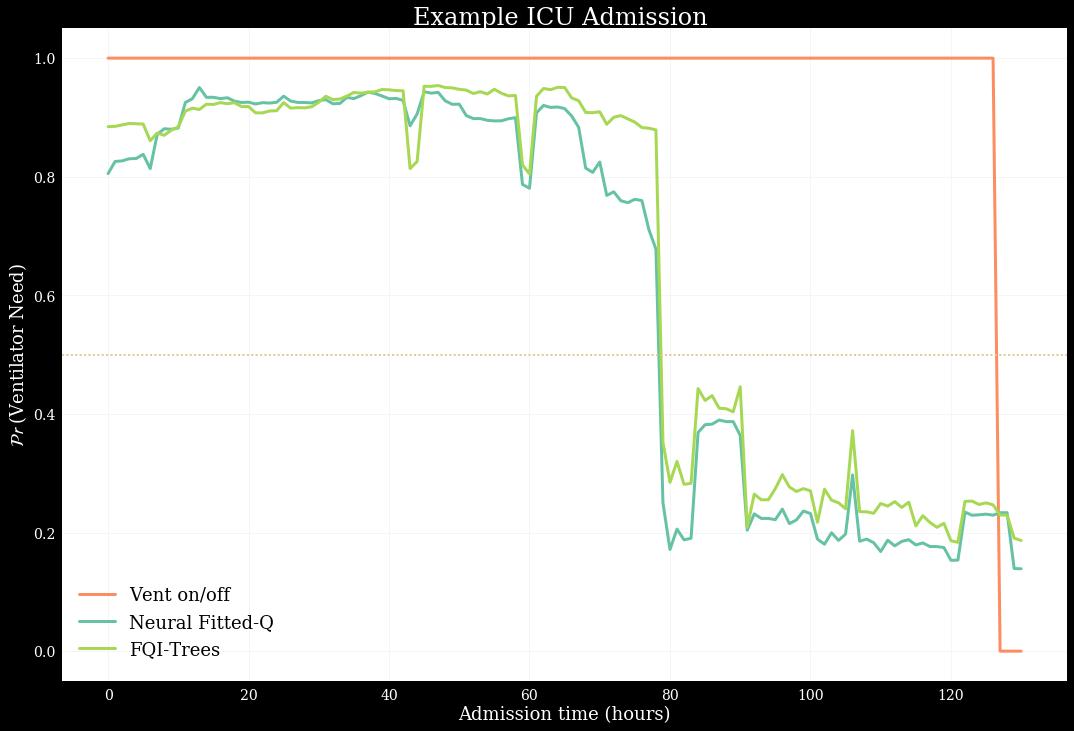

In [128]:
figsize(18,12)
h=1800
h=1509
#h=1947
#h=2020
#h=1996
for h in range(1800,1801):
    figure()
    plt.style.use('seaborn-whitegrid')

    sns.set(rc={'ytick.color':'white','xtick.color': 'white', 'axes.facecolor':'white','font.family': [u'serif'],
                'figure.facecolor':'black', 'grid.color':'whitesmoke'})

    plot(piHosp(hadms[h], 0),color=sns.color_palette('Set2')[1], linewidth=3)
    plot(piRL(hadms[h],0,ptree2),color=sns.color_palette('Set2')[0], linewidth=3)
    plot(piRL(hadms[h],0,ptree1),color=sns.color_palette('Set2')[4], linewidth=3)
    #plot(np.transpose(clfbb.predict_proba(sclb.transform(samplesb[hadms[h]])))[1], color=sns.color_palette('Set2', 10)[2], linewidth=1, linestyle='-.')

    plt.axhline(y=0.5, color=sns.color_palette('Set2',8)[6], linestyle=':')
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    ylabel('$\mathcal{Pr } $ (Ventilator Need)', fontsize=18,color='white')
    xlabel('Admission time (hours)', fontsize=18,color='white')
    leg = plt.legend(['Vent on/off','Neural Fitted-Q','FQI-Trees'], bbox_to_anchor=(0., 0.01, 1., 2), loc=3,fontsize=18)
    for text in leg.get_texts():
        plt.setp(text, color = 'black')
    title('Example ICU Admission ', fontsize=24,color='white')
    #title('Admission '+ str(h), fontsize=14,color='white')

In [967]:
np.transpose(clfbb.predict_proba(sclb.transform(samplesb[hadms[h]])))[0]

array([ 0.35080098,  0.47145193,  0.37338705,  0.31931257,  0.34853971,
        0.18083239,  0.41841827,  0.12328629,  0.16538427,  0.22051829,
        0.10043798,  0.02813932,  0.04794391,  0.00826184,  0.03263176,
        0.04255657,  0.0186374 ,  0.04426986,  0.04715892,  0.03390587,
        0.03398104,  0.04214703,  0.08197853,  0.07596206,  0.07021881,
        0.09264107,  0.07477161,  0.09686847,  0.09706919,  0.08219002,
        0.07358891,  0.1588805 ,  0.13830191,  0.14055614,  0.28021196,
        0.13065117,  0.35274613,  0.31007333,  0.27217339,  0.11693534,
        0.15206319,  0.15474241,  0.07877804,  0.06535414,  0.08253577,
        0.03318829,  0.02743027,  0.04468369,  0.14218088,  0.12743108,
        0.18435929,  0.11628439,  0.15724988,  0.13425363,  0.09101624,
        0.09302058,  0.16291374,  0.05912157,  0.09133442,  0.16572357,
        0.24752766,  0.1860422 ,  0.08194416,  0.06012708,  0.0664687 ,
        0.07808337,  0.13246851,  0.13513539,  0.11857231,  0.10

In [952]:
len(samplesb[hadms[h]])

131

In [931]:
np.concatenate(allSamples[hadms[1996]]['currStates'][100])[:24]

array([   1.  ,    1.  ,    0.  ,   43.  ,  106.  ,  109.  ,   26.  ,
         98.  ,   93.  ,   10.  ,   40.  ,   46.  ,    7.43,   98.  ,
         17.  ,    0.  ,   36.  ,   30.  ,    3.28,  430.  ,   10.  ,
          0.7 ,   30.  ,   18.  ])

In [934]:
np.concatenate(allSamples[hadms[1996]]['currStates'][1])[:24]

array([   1.  ,    1.  ,    0.  ,   43.  ,  106.  ,  131.5 ,   22.  ,
         93.  ,   73.5 ,   10.  ,   50.  ,   34.  ,    7.39,   81.  ,
         13.  ,   49.  ,   33.  ,   28.  ,   11.3 ,  489.  ,    5.  ,
          1.4 ,   43.1 ,   30.  ])

In [929]:
feats

['Admit Type',
 'Ethnicity',
 'Gender',
 'Age',
 'Weight',
 'Heart Rate',
 'Respiratory Rate',
 '$O_2$ saturation pulseoxymetry',
 'NI Blood Pressure (Mean)',
 '$O_2$ Flow',
 'Inspired $O_2$ Fraction',
 'Arterial $CO_2$ Pressure',
 'Arterial pH',
 'Arterial $O_2$ pressure',
 'Mean Airway Pressure',
 'Ventilator Mode',
 'Peak Insp. Pressure',
 'Plateau Pressure',
 'Minute Volume',
 'Tidal Volume',
 'PEEP set',
 'Creatinine',
 'Hematocrit',
 'Blood Urea Nitrogen (BUN)',
 'Fentanyl (Concentrate)',
 'Midazolam (Versed)',
 'Propofol',
 'Fentanyl',
 'Dexmedetomidine (Precedex)',
 'Morphine Sulfate',
 'Hydromorphone (Dilaudid)',
 'Lorazepam (Ativan)',
 'Duration',
 'Intubations']

In [14]:
def piHosp(h, adim): 
    pi = np.transpose(testActions[h])[adim]
    return pi
    
def piRL(h, adim, policyTree):
    test = np.transpose(np.transpose(testStates[h])[:24])
    pi = np.transpose(policyTree.predict_proba(test))[0]
    #pi = possibleActions[np.transpose(policyTree.predict(test))]
    return pi

In [1016]:
len(reint)

47

In [1015]:
reint = []
for i in range(len(testPts)):
    if max(np.concatenate((np.transpose(allSamples[testPts[i]]['currStates']))[33])) > 1:
        print i, max(np.concatenate((np.transpose(allSamples[testPts[i]]['currStates']))[33]))
        reint.append(i)

13 2.0
24 2.0
25 3.0
45 3.0
58 2.0
68 2.0
83 2.0
85 2.0
87 3.0
96 2.0
108 3.0
110 3.0
127 2.0
131 2.0
147 2.0
161 3.0
171 2.0
191 2.0
196 2.0
197 2.0
207 2.0
220 2.0
221 2.0
244 2.0
249 2.0
257 2.0
280 2.0
304 3.0
311 2.0
325 3.0
331 2.0
346 2.0
355 2.0
375 2.0
377 2.0
399 2.0
405 2.0
410 2.0
411 2.0
416 2.0
442 2.0
448 2.0
490 2.0
494 2.0
497 2.0
516 2.0
519 2.0


In [913]:
with open("baselinecomparison.pkl",'rb') as f: (samplesb, targetsb, sclb, clfbb) = pickle.load(f)

In [544]:
fpr, tpr, threshold = roc_curve(np.concatenate([piHosp(h, 0) for h in testStates.keys()[:]]), np.concatenate([piRL(h, 0, ptree2) for h in testStates.keys()[:]]))

In [563]:
fpr1, tpr1, threshold1 = roc_curve(np.concatenate([piHosp(h, 0) for h in testStates.keys()[:]]), np.concatenate([piRL(h, 0, ptree1) for h in testStates.keys()[:]]))

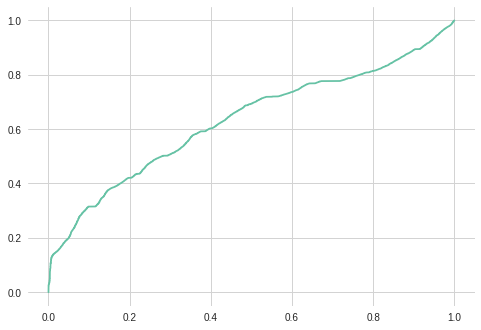

In [564]:
plot(fpr1,tpr1, color=sns.color_palette('Set2')[0])

In [565]:
auc(fpr, tpr), auc(fpr1, tpr1)

(0.66722849544351714, 0.63178215901418033)

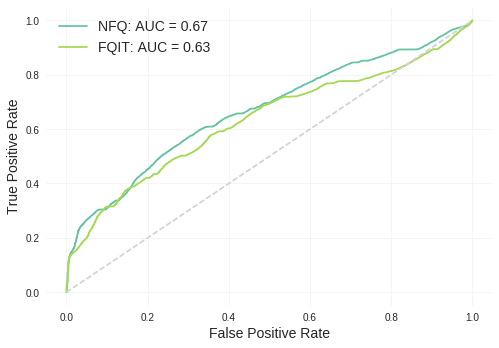

In [993]:
plot(fpr,tpr, color=sns.color_palette('Set2')[0])
hold(True)
plot(fpr1,tpr1, color=sns.color_palette('Set2')[4])
ylabel('True Positive Rate',fontsize=14); xlabel('False Positive Rate',fontsize=14)
plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1), '--', color='lightgrey')
plt.legend(['NFQ: AUC = 0.67', 'FQIT: AUC = 0.63'], fontsize=14)

--------------------------------------

In [599]:
## Testing ##

def piHosp(h, adim): 
    pi = np.transpose(testActions[h])[adim]
    return pi
    
def piRL(h, adim, policyTree):
    test = np.transpose(np.transpose(testStates[h])[:24])
    pi = np.transpose(policyTree.predict(test))
    return 1-pi

total = {}; vMatches = {}; sMatches = {}
frac_vMatches = []; frac_sMatches = []; 
fqi = True
for h in testPts:
    total[h] = len(piHosp(h, 0))
    vMatches[h] = np.where(piHosp(h, 0) - piRL(h, 0, ptree2) == 0)[0]
    sMatches[h] = np.where(abs(piHosp(h, 1) - piRL(h, 1, ptree2)) <= 1)[0]
    frac_vMatches.append(100 * len(vMatches[h])/float(total[h])) 
    frac_sMatches.append(100 * len(sMatches[h])/float(total[h])) 
    
frac_vMatches = np.asarray(frac_vMatches)
frac_sMatches = np.asarray(frac_sMatches)

(array([  7.,   7.,  10.,  12.,  14.,  14.,  10.,   4.,   8.,   6.,   7.,
         10.,   5.,  10.,   6.,   8.,  12.,   8.,  12.,   6.,  17.,  15.,
          7.,   8.,   9.,  10.,  17.,  11.,   9.,   9.,  15.,  15.,   4.,
         16.,   8.,  11.,   9.,  10.,  14.,   6.,  17.,  13.,  11.,  13.,
         16.,  15.,  10.,  12.,  20.,   7.]),
 array([   0.75757576,    2.74242424,    4.72727273,    6.71212121,
           8.6969697 ,   10.68181818,   12.66666667,   14.65151515,
          16.63636364,   18.62121212,   20.60606061,   22.59090909,
          24.57575758,   26.56060606,   28.54545455,   30.53030303,
          32.51515152,   34.5       ,   36.48484848,   38.46969697,
          40.45454545,   42.43939394,   44.42424242,   46.40909091,
          48.39393939,   50.37878788,   52.36363636,   54.34848485,
          56.33333333,   58.31818182,   60.3030303 ,   62.28787879,
          64.27272727,   66.25757576,   68.24242424,   70.22727273,
          72.21212121,   74.1969697 ,   76.181

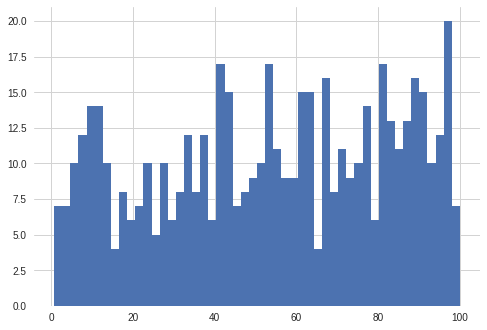

In [601]:
hist(frac_vMatches, 50)

In [602]:
[vMatches[h] for h in testPts]

[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [608]:
(piHosp(hadms[1903], 0), piRL(hadms[1903], 1, ptree1))

(array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.

In [134]:
[ptree2.predict_proba(np.transpose(np.transpose(trainStates[106507])[:24]))][0]

array([[  1.25252934e-03,   1.23232463e-01,   1.63955244e-01,
          2.50643806e-01,   1.13661782e-01,   3.47254176e-01],
       [  1.25252934e-03,   1.22229436e-01,   1.64722071e-01,
          2.53231871e-01,   1.10958275e-01,   3.47605818e-01],
       [  3.15614359e-03,   9.86347239e-02,   1.40543902e-01,
          2.61241756e-01,   1.55233941e-01,   3.41189533e-01],
       ..., 
       [  3.96238684e-04,   6.60123359e-02,   8.30294789e-02,
          2.98020909e-01,   1.57175089e-01,   3.95365949e-01],
       [  6.86054826e-04,   6.22808682e-02,   7.50292787e-02,
          2.92864512e-01,   1.70766459e-01,   3.98372827e-01],
       [  6.86054826e-04,   6.43881381e-02,   7.79557341e-02,
          3.00340078e-01,   1.60339538e-01,   3.96290457e-01]])

In [48]:
possibleActions

array([(1.0, 0.0), (1.0, -1.0), (1.0, 1.0), (0.0, -1.0), (0.0, 0.0),
       (0.0, 1.0)], dtype=object)

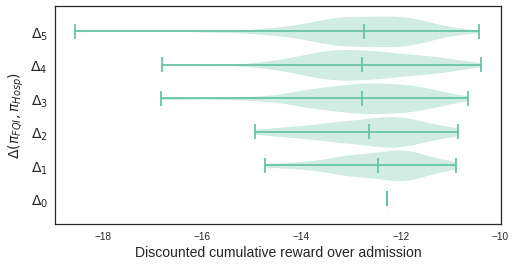

In [779]:
#bins = stats.mstats.mquantiles(frac_vMatches, [0, 1./5, 2./5, 3./5, 4./5, 1])
# gamma = 0.9
# discount = []
# for i in range(max([len(testSamples[h]) for h in testPts])):
#     discount.append(gamma**i)

# bins=[100, 93, 85, 70, 55, 0]    
# dist0 = np.where(frac_vMatches >= bins[0])[0]
# dist1 = np.where(np.logical_and((frac_vMatches >= bins[1]), (frac_vMatches < bins[0])))[0]
# dist2 = np.where(np.logical_and((frac_vMatches >= bins[2]), (frac_vMatches < bins[1])))[0]
# dist3 = np.where(np.logical_and((frac_vMatches >= bins[3]), (frac_vMatches < bins[2])))[0]
# dist4 = np.where(np.logical_and((frac_vMatches >= bins[4]), (frac_vMatches < bins[3])))[0]
# dist5 = np.where(np.logical_and((frac_vMatches >= bins[5]), (frac_vMatches < bins[4])))[0]
# vdists = [dist0, dist1, dist2, dist3, dist4, dist5]

# sbins=[100, 95, 85, 70, 30, 0]    
# sdist0 = np.where(frac_sMatches >= sbins[0])[0]
# sdist1 = np.where(np.logical_and((frac_sMatches >= sbins[1]), (frac_sMatches < sbins[0])))[0]
# sdist2 = np.where(np.logical_and((frac_sMatches >= sbins[2]), (frac_sMatches < sbins[1])))[0]
# sdist3 = np.where(np.logical_and((frac_sMatches >= sbins[3]), (frac_sMatches < sbins[2])))[0]
# sdist4 = np.where(np.logical_and((frac_sMatches >= sbins[4]), (frac_sMatches < sbins[3])))[0]
# sdist5 = np.where(np.logical_and((frac_sMatches >= sbins[5]), (frac_sMatches < sbins[4])))[0]
# sdists = [sdist0, sdist1, sdist2, sdist3, sdist4, sdist5]

# os = 1500; finHr = {}; nd=0
# for d in vdists:
#     finHr[nd] = [sum(array(discount[:len(testRewards[hadms[i+os]][::1])]) * testRewards[hadms[i+os]][::-1]) for i in d]
    
#     #finHr[nd] = ([mean(testRewards[hadms[i+os]][:]) for i in d])                   # mean reward 
#     #finHr[nd] =  [testSamples[hadms[i+os]][len(testSamples[hadms[i+os]])-1][30] for i in d]   # num intubations
#     nd = nd + 1
# #for i in np.where([finHr[5][l] == 0 for l in range(len(finHr[5]))])[0]: finHr[5][i] = 1 

plt.style.use('seaborn-white')
#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'grid.color':'lightgrey'})

pos = [1, 2, 3, 4, 5, 6]
data = [finHr[i] for i in range(0,6)]
figure(figsize=(8,4))
fig = plt.subplot()
violin_parts = plt.violinplot(data, pos, vert=False, widths=0.9, showmeans=True, showextrema=True, showmedians=False)
fig.set_yticklabels(['','$\Delta_0$','$\Delta_1$','$\Delta_2$','$\Delta_3$','$\Delta_4$','$\Delta_5$'], size=14)
fig.set_xlabel('# Intubations over admission', size=14)
fig.set_xlabel('Discounted cumulative reward over admission', size=14)
fig.set_ylabel('$\Delta(\pi_{FQI}, \pi_{Hosp})$', size=14)

colour0 = sns.color_palette('Set2')[0]
colour1 = sns.color_palette('Set2')[1]

for pc in violin_parts['bodies']: pc.set_facecolor(colour0); pc.set_edgecolor(colour0)
for pc in ['cmeans', 'cmins', 'cmaxes', 'cbars']: violin_parts[pc].set_color(colour0)
plt.show()

In [664]:
gamma = 0.9
discount = []
for i in range(max([len(testSamples[h]) for h in testPts])):
    discount.append(gamma**i)

In [681]:
a = (array(discount[:len(testRewards[h][::1])]) * testRewards[h][::-1])

In [686]:
sum(a)

-13.353303950445538

In [673]:
testRewards[h][::-1] * discount[:len(testRewards[h][::1])]

TypeError: can't multiply sequence by non-int of type 'list'

In [659]:
max([len(testSamples[h]) for h in testPts])

1378

In [612]:
with open("pickles/17maypolicies.pkl",'wb') as f: pickle.dump((imp1, fi1, ptree1, imp2, fi2, ptree2), f)

In [729]:
with open("pickles/17maypoliciestest.pkl",'wb') as f: pickle.dump((vdists, frac_vMatches), f)

In [632]:
for d in vdists:
    print max(d)

62
527
526
524
529
528
